# Dictionary formation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tof_calculator 
import pulse_former 
import defect_map_handling 

In [2]:
# Parameters
Nx = 20 # limited due to the opening angle
Nz = 200
Nt = Nz
c0 = 6300 #[m/S]
fS = 80*10**6 #[Hz] 
fC = 5*10**6 #[Hz] 
alpha = 20*10**12 #[Hz]**2
dx = 0.5*10**-3 #[m]
dz = 0.5* c0/(fS)
wavelength = 1.26* 10**-3 # [m]
# defect position: p_defect
p_def_idx = np.array([10, 91])
p_def = np.array([p_def_idx[0]*dx, p_def_idx[1]*dz])
# defect map: defmap
dmh = defect_map_handling.DefectMapSingleDefect2D(p_def, Nx, Nz, dx, dz)
dmh.generate_defect_map()
defmap_true = dmh.get_defect_map()

## ToF calculation

In [3]:
p_scan = np.array([[2.7*dx, 0*dz], [5.1*dx, 0*dz]])
tofcalc = tof_calculator.ToFforDictionary2D(c0, Nx, Nz, dx, dz, p_scan)
tofcalc.calculate_tof(calc_grad = True)
tof = tofcalc.get_tof()    
grad_tof = tofcalc.get_grad_tof()

## Dictionary formation

In [ ]:
# Dictionary formation
pformer = pulse_former.PulseFormerGabor(Nt, fS, fC, alpha)
K = p_scan.shape[0]
L = Nx*Nz
H = np.zeros((K*Nt, L)) # Base of SAFT matrix
J = np.array(H) # Base of Jacobian matrix
for k in range(K):
    for l in range(L):
        tau = tof[k, l]
        grad_tau = grad_tof[k, l]
        pformer.calculate_ip_pulse(tau)
        pformer.calculate_grad_ip(grad_tau)
        # Allocate pulses to the dictionaries
        H[k*Nt:(k+1)*Nt, l] = pformer.get_ip_pulse()
        J[k*Nt:(k+1)*Nt, l] = pformer.get_grad_ip()

In [4]:
class DictionaryFormer():
    def __init__(self, Nt, fS, fC, alpha):
        self.pformer = pulse_former.PulseFormerGabor(Nt, fS, fC, alpha)
        self.Nt = int(Nt)
        self.H = None # Base of the SAFT matrix
        self.J = None # Base of the Jacobian matrix
    
            
    def generate_dictionary(self, tof, grad_tof = None):
        M = self.Nt
        K = tof.shape[0]
        L = tof.shape[1]
        self.H = np.zeros((K*M, L))
        self.J = np.array(self.H)
        for k in range(K):
            for l in range(L):
                # SAFT matrix
                tau = tof[k, l]
                self.pformer.calculate_ip_pulse(tau)
                self.H[k*M:(k+1)*M, l] = self.pformer.get_ip_pulse()
                # Jacobian matrix
                if grad_tof is not None:
                    grad_tau = grad_tof[k, l]
                    self.pformer.calculate_grad_ip(grad_tau)
                    self.J[k*M:(k+1)*M, l] = self.pformer.get_grad_ip()

    
    def get_SAFT_matrix(self):
        return self.H
    
    def get_Jacobian_matrix(self):
        return self.J
        
        

In [5]:
dformer = DictionaryFormer(Nt, fS, fC, alpha)
dformer.generate_dictionary(tof, grad_tof)
H = dformer.get_SAFT_matrix()
J = dformer.get_Jacobian_matrix()

## Check the dictionary w/ A-Scans

In [6]:
ascans = np.dot(H, defmap_true)

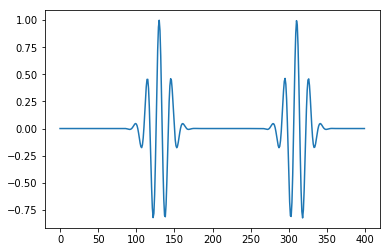

In [7]:
plt.plot(ascans)

In [8]:
grad_ascans = np.dot(J, defmap_true)

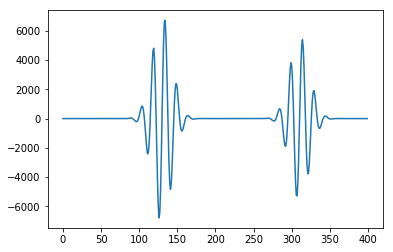

In [9]:
plt.plot(grad_ascans)